Load data


In [104]:
# -*- coding: utf-8 -*-
"""
Created on Sun Dec 17 15:09:34 2017

@author: Frederic Chazal - All rigths reserved
"""

import numpy as np
import pandas as pd
import pickle 

import csv
import time as tm
import seaborn as sns

#Getting the data
#Setting the path to the data
data_path = "./data/"

DowJones_pd = pd.read_csv(data_path + "DowJones.csv",header=0,delimiter=",")
Nasdaq_pd = pd.read_csv(data_path + "Nasdaq.csv",header=0,delimiter=",")
Russell2000_pd = pd.read_csv(data_path + "Russell2000.csv",header=0,delimiter=",")
SP500_pd = pd.read_csv(data_path + "SP500.csv",header=0,delimiter=",")

DowJones_pd.head()

#Close is the daily return
DJ = DowJones_pd.Close
Nasdaq = Nasdaq_pd.Close
Rus = Russell2000_pd.Close
SP500 = SP500_pd.Close

#convert to numpy ND array
DJ = np.asarray(DJ)
Nasdaq = np.asarray(Nasdaq)
Rus = np.asarray(Rus)
SP500 = np.asarray(SP500)

DJ = DJ.reshape(len(DJ),1)
Nasdaq = Nasdaq.reshape(len(Nasdaq),1)
Rus = Rus.reshape(len(Rus),1)
SP500 = SP500.reshape(len(SP500),1)
#above 4 arrays have shape (7301,4)
#element 7301 corresponds to day 1987-12-23 and first element corresponds to day 2016-12-08
#every row represents a single day
ts = np.concatenate((DJ.transpose(),Nasdaq.transpose(),Rus.transpose(),SP500.transpose()))

Compute the log returns as in section 4 of the paper

In [167]:
log_returns = np.diff(-np.log(ts),axis=1) #log(P(i,j)/P(i,j-1))
#computing the log returns eliminates the date '1987-12-23' corresponding to last row because this date
#does not have previous value

"""
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(log_returns)
norm_log_returns = scaler.transform(log_returns)

"""

Extract ordered time series sliding window by specifying the end data and the winodw size.

In [333]:
def get_date_index(date,df):
    """
    Returns the index of the row corresponding the the input @date in the dataframe @df
    
    @date: string of the form 'yyyy-mm--dd'
    @df : pandas dataframe
    """
    
    index_list =df.index[df['Date']==date].tolist()
    try:
        out= index_list[0]
    except:
        print('Day {} is missing from data! Please enter a valid date.'.format(date))
        out = None
        
    return out
              
  

def get_sliding_window_from_date_index(data_array,date_index,window_size):
    """
    Returns time ordered sliding window of size @window_size starting from input @date
    
    @data_array: input array of multivariate time series of shape (d,n) where d is the number of 1D time series
    @date:string of the form 'yyyy-mm--dd'
    @window_size: integer value of the size of the wanted window
    """

    
    #day @date corresponds to @data_array[date_index]
    #next rows correspond to previous days
    sliding_window = data_array[:,date_index:date_index + window_size]
    
    #flip to have increasing order i.e next days will come after in the flipped array
    time_ordered_sliding_window = np.flip(sliding_window,1)
    return time_ordered_sliding_window
    
def get_sliding_window_from_date(data_array,date,window_size,df=DowJones_pd):
    """
    Returns time ordered sliding window of size @window_size starting from input @date
    
    @data_array: input array of multivariate time series of shape (d,n) where d is the number of 1D time series
    @date:string of the form 'yyyy-mm--dd'
    @window_size: integer value of the size of the wanted window
    """

    date_index = get_date_index(date,df)
    time_ordered_sliding_window = get_sliding_window_from_date_index(data_array,date_index,window_size)
    
    return time_ordered_sliding_window
    
    

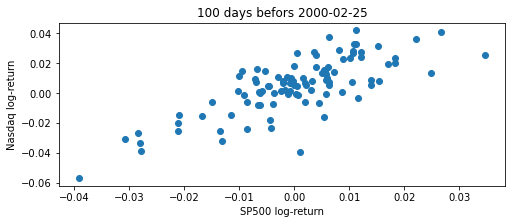

In [260]:
ending_date = '2000-02-25'
window_size = 100
window = get_sliding_window(log_returns,ending_date,window_size,df=DowJones_pd)
assert window.shape[1] == window_size
import matplotlib.pyplot as plt
#plot needs to be normalized to match Figure 7 of the paper

sp500_w = window[3]
nasdaq_w = window[1]
plt.figure(figsize=(8,3))
plt.scatter(sp500_w,nasdaq_w)
plt.xlabel('SP500 log-return')
plt.ylabel('Nasdaq log-return')
tt =plt.title('{} days befors {}'.format(window_size,ending_date))

Compute persistance diagram of the sliding window using gudhi library

In [177]:
import gudhi as gd
import gudhi.representations
from gudhi import plot_persistence_diagram

In [359]:
#Fix parameters to reproduce Figure 8 from paper

ending_date = '2008-09-15'#'2000-03-10'
window_size = 50
window = get_sliding_window(log_returns,ending_date,window_size,df=DowJones_pd)

In [360]:
skeleton = gd.RipsComplex(points = window.T, max_edge_length = 0.8)
Rips_simplex_tree_sample = skeleton.create_simplex_tree(max_dimension = 2)
dgm = Rips_simplex_tree_sample.persistence()

In [268]:
len(dgm) #total number of points in dimensions 0 and 1

60

In [264]:
for i in range(25):
    print(dgm[i])

(1, (0.01174692136803735, 0.015351498872754808))
(1, (0.016719200011755603, 0.02014989682275647))
(1, (0.010629295114415975, 0.011802707901758093))
(1, (0.012948198648351183, 0.01375008663417751))
(1, (0.005951898017778947, 0.006647768837374706))
(1, (0.007939437192028186, 0.008447284027362157))
(1, (0.0127319401705889, 0.012909056705414756))
(1, (0.01308677870958075, 0.013150327071677724))
(0, (0.0, inf))
(0, (0.0, 0.026207998790701025))
(0, (0.0, 0.015854203508576997))
(0, (0.0, 0.015616703187384054))
(0, (0.0, 0.013907033372525291))
(0, (0.0, 0.012311381012822266))
(0, (0.0, 0.011649529726708279))
(0, (0.0, 0.011007210468349782))
(0, (0.0, 0.010935097515138714))
(0, (0.0, 0.010867894892211924))
(0, (0.0, 0.01021127064035606))
(0, (0.0, 0.01014530289968075))
(0, (0.0, 0.010094637838877688))
(0, (0.0, 0.010019377207787492))
(0, (0.0, 0.009896278689221567))
(0, (0.0, 0.009893751986070433))
(0, (0.0, 0.009766533856146146))


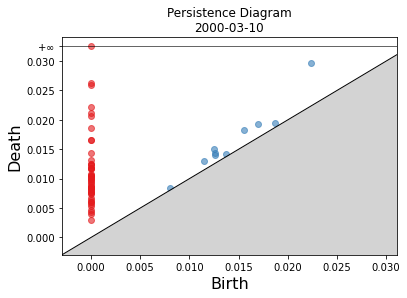

In [322]:
gd.plot_persistence_diagram(dgm)
tt = plt.title('Persistence Diagram\n{}'.format(ending_date))

The obtained diagram is comparable to the persistence diagram appearing in Figure 8 of the paper for the same date. 1-dimensional features are displayed in blue dots in the above figure, and in the paper they are displayed using red triangles.


We will now compute the persistence landscapes as described in the paper.

In [242]:
dim1_barcodes = Rips_simplex_tree_sample.persistence_intervals_in_dimension(1)
dim1_barcodes

array([[0.1613538 , 0.16713664],
       [0.13005565, 0.20636914],
       [0.25569687, 0.2571    ],
       [0.20103325, 0.26460104],
       [0.32684772, 0.34799313],
       [0.35325511, 0.35985389],
       [0.33334991, 0.36124705],
       [0.35748203, 0.40320707],
       [0.43015295, 0.43325504],
       [0.41677983, 0.46894255],
       [0.5370051 , 0.57058081],
       [0.45046056, 0.62286721],
       [0.63108376, 0.66548803]])

Compute persistance landscape as in Equations (2.1) and (2.2) in section 2 of the paper.

In [278]:
def f_pw(diagram_point_coordinates,x):
    """
    Piecewise linear function
    """
    
    lower , upper = diagram_point_coordinates
    mid = (lower+upper)/ 2
    
    if x<=lower:
        return 0
    
    else:
        if x<upper:
            if x<= mid:
                return x-lower
            else:
                return upper - x
            
        else:
            return 0
    

def get_persistence_landscapes(dgm,k,x_min,x_max,nb_nodes,nb_ld):
    
    #initialize empty set of 
    dim_features = []
    
    #initialize landscapes to zero
    landscapes = np.zeros((nb_ld, nb_nodes))
    
    #loop over sampled points over the interval [x_min,x_max]
    for i,x in enumerate(np.linspace(x_min,x_max,nb_nodes)):
        x_evals = []
        #For every point compute the sequence of landscape values
        
        for tup in dgm:
            
            if tup[0] == k:
                #k dimensional features of the persistence diagram
                dgm_ftr_point = tup[1]
                #evaluate x using the piecewise lineare function for the corresponding feature point
                point_eval = f_pw(dgm_ftr_point,x)
                #add elemt to the evaluations list
                x_evals.append(point_eval)
                
        #sort evaluations 
        x_evals.sort()
        
        #Pick a number of first maximal values leave the others to zero
        nb_max = min(nb_ld,len(x_evals)) 
        landscapes[:nb_max,i] = x_evals[::-1][:nb_max] 
        
    return landscapes
    
    

In [361]:
k = 1 #1-dimensional features
x_min = 0
x_max = 0.05 #aucune idée pourquoi cette valeur mais ça me donne une jolie figure là dessous
nb_nodes = 1000
nb_ld = 2

landscapes = get_persistence_landscapes(dgm,k,x_min,x_max,nb_nodes,nb_ld)

In [335]:
np.linalg.norm(landscapes[0],ord=1)

0.3598045688437236

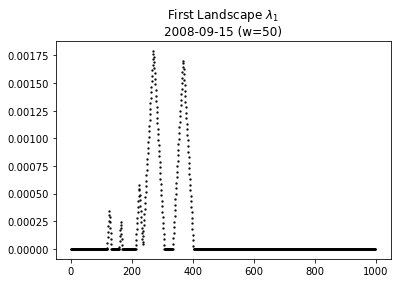

In [362]:
plt.scatter(np.arange(nb_nodes),landscapes[0],s=2,alpha=0.8,c='black')
tt = plt.title('First Landscape $\lambda_1$\n{} (w={})'.format(ending_date,window_size))

The obtained figure corresponds exactly to the persistence landscape shown in Figure 8 of the paper, corresponding to the date 2000-03-10.

In the next section, we will try to reproduce the results in paper 8 by proceeding as follows:

i) Fix a window size $w$ and a day $d$. From the set of $w$ datapoints in $\mathbb{R}^{4}$, compute persistence diagram using the Rip-Vitoris filtration.

ii) Compute the L1 and L2 norms of the first persistence landscape $\lambda_1$. Persistence landscapes are obtained using only 1-dimensional features of the persistence diagram.

iii) Repeate for all days in the period of interest. This will give us a two 1D time series, one for L1 norm and one for L2 norm.  

In [366]:
import tqdm.notebook as tq

def get_lansdscape_norms_ts(log_returns,w,nb_days,nb_ld,nb_nodes,x_min,x_max,k):
    
    
    #initialize landscape norms
    L1_norms =[]
    L2_norms = []
    for day in tq.tqdm(range(nb_days)):

        #get ordered time series sliding window for the correspoding day
        ts_sw = get_sliding_window_from_date_index(log_returns,day,w)

        #compute persistence diagram
        skeleton = gd.RipsComplex(points = ts_sw.T, max_edge_length = 0.8)
        Rips_simplex_tree_sample = skeleton.create_simplex_tree(max_dimension = 2)
        dgm = Rips_simplex_tree_sample.persistence()

        #compute first persistence landscape
        landscapes = get_persistence_landscapes(dgm,k,x_min,x_max,nb_nodes,nb_ld)
        lambda_1 = landscapes[0]
        L1_norms.append(np.linalg.norm(lambda_1,ord=1))
        L2_norms.append(np.linalg.norm(lambda_1))
        
    return np.array(L1_norms[::-1]), np.array(L2_norms[::-1])

In [367]:
#set window size
w = 50
nb_days = log_returns.shape[1] - w +1

#Set persistence landscape parameters
k = 1 #1-dimensional features
x_min = 0
x_max = 0.05 #aucune idée pourquoi cette valeur mais ça me donne une jolie figure là dessous
nb_nodes = 1000
nb_ld = 2


print('Compute L1 and L2 norms of persistence landscapes for {} days...'.format(nb_days))

L1_norms , L2_norms = get_lansdscape_norms_ts(log_returns,w,nb_days,nb_ld,nb_nodes,x_min,x_max,k)

Compute L1 and L2 norms of persistence landscapes for 7251 days...


In [376]:
norm_L1_norms[begin_index:end_index]

array([], dtype=float64)

In [378]:
end_index

4214

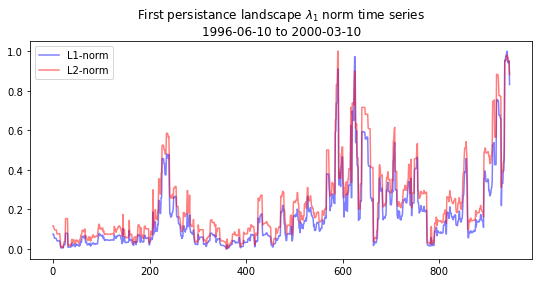

In [427]:
norm_L1_norms = np.flip(L1_norms)#/L1_norms.max()
norm_L2_norms = np.flip(L2_norms)#/L2_norms.max()

begin_date = '1996-06-10'
end_date  = '2000-03-10'
begin_index = get_date_index(begin_date,DowJones_pd)
#begin_index = end_index+960
end_index = get_date_index(end_date,DowJones_pd)
l1_plot = norm_L1_norms[end_index:begin_index]
l1_plot = np.flip(l1_plot)
l1_plot -= l1_plot.min()
#normalize
l1_plot/=l1_plot.max()
l2_plot = norm_L2_norms[end_index:begin_index]
l2_plot = np.flip(l2_plot)
#normalize
l2_plot -= l2_plot.min()
l2_plot/=l2_plot.max()

plt.figure(figsize = (9,4))
plt.plot(l1_plot,'-b',alpha=0.5,label ='L1-norm')
plt.plot(l2_plot,'-r',alpha=0.5,label ='L2-norm')
tt =plt.title('First persistance landscape $\lambda_1$ norm time series\n{} to {}'.format(begin_date,end_date))
lg = plt.legend()


The obtained figure is very similar to the time series displayed in Figure 9 of the paper https://arxiv.org/abs/1703.04385 . We obtain the same curves overall, we can see the same peaks in particular. 

However, the main difference is that in our result, the L1-norm curve lies below the L2-norm curve, as opposed to what is observed in the figure 9. This might be an effect of normalization, below we plot separately the two curves without normalization:

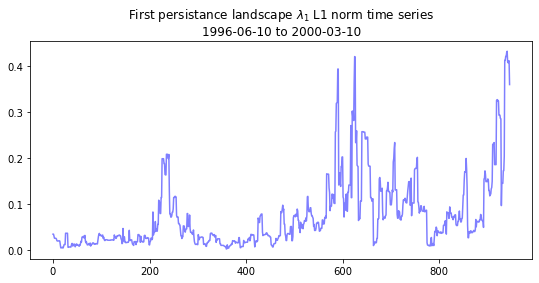

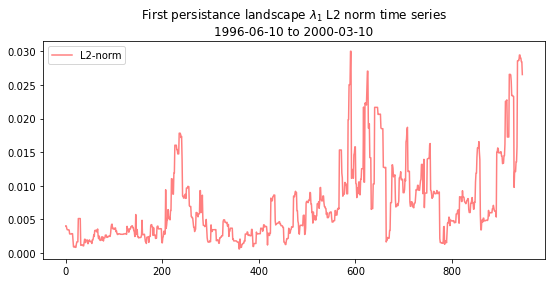

In [425]:
plt.figure(figsize = (9,4))
tt =plt.title('First persistance landscape $\lambda_1$ L1 norm time series\n{} to {}'.format(begin_date,end_date))
plt.plot(l1_plot,'-b',alpha=0.5,label ='L1-norm')

plt.figure(figsize = (9,4))
plt.plot(l2_plot,'-r',alpha=0.5,label ='L2-norm')
tt =plt.title('First persistance landscape $\lambda_1$ L2 norm time series\n{} to {}'.format(begin_date,end_date))
lg = plt.legend()

In [395]:
end_index-begin_index

-949

In [356]:
last_day = get_date_index('2000-03-10',DowJones_pd)

In [357]:
last_day

4214

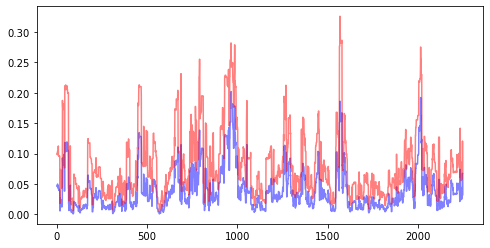

In [358]:

plt.figure(figsize = (8,4))
plt.plot(L1_norms[:last_day:-1]/np.array(L1_norms[::-1]).max(),'-b',alpha=0.5)
plt.plot(L2_norms[:last_day:-1]/np.array(L2_norms[::-1]).max(),'-r',alpha=0.5)